# Import Library

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import pickle

# Konfigurasi Global
DATASET_PATH = "dataset/anemia_dataset.xlsx"
MODELS_DIR = "models"
MODEL_NAME = "anemia_binary_model"
ONNX_OPS_VERSION = 13 # Opset untuk konversi ONNX

# Load Data 

In [ ]:
print("--- Memulai Pipeline Deteksi Anemia ---")

# Buat folder dataset jika belum ada
os.makedirs(os.path.dirname(DATASET_PATH), exist_ok=True)

try:
    df = pd.read_excel(DATASET_PATH)
    print(f"Dataset berhasil dimuat dari '{DATASET_PATH}'.")
except FileNotFoundError:
    print(f"Error: File '{DATASET_PATH}' tidak ditemukan. Pastikan 'dataset/anemia_dataset.xlsx' ada.")
except Exception as e:
    print(f"Error saat memuat dataset: {e}")

--- Memulai Pipeline Deteksi Anemia ---
Dataset berhasil dimuat dari 'dataset/anemia_dataset.xlsx'.


# Data Understanding

In [96]:
print(f"\nBentuk dataset: {df.shape}")
print("\nInformasi umum dataset:")
df.info()


Bentuk dataset: (15300, 29)

Informasi umum dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15300 entries, 0 to 15299
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GENDER               15300 non-null  int64  
 1   WBC                  15300 non-null  float64
 2   NE#                  15300 non-null  float64
 3   LY#                  15300 non-null  float64
 4   MO#                  15300 non-null  float64
 5   EO#                  15300 non-null  float64
 6   BA#                  15300 non-null  float64
 7   RBC                  15300 non-null  float64
 8   HGB                  15300 non-null  float64
 9   HCT                  15300 non-null  float64
 10  MCV                  15300 non-null  float64
 11  MCH                  15300 non-null  float64
 12  MCHC                 15300 non-null  float64
 13  RDW                  15300 non-null  float64
 14  PLT                  15300 non-n

In [97]:
print("\nLima baris pertama dataset:")
print(df.head())


Lima baris pertama dataset:
   GENDER    WBC   NE#   LY#   MO#   EO#   BA#   RBC   HGB   HCT  ...   SDTSD  \
0       1  10.63  6.31  2.79  0.91  0.56  0.06  4.31  12.7  37.6  ...  248.90   
1       1   5.08  2.50  1.87  0.43  0.26  0.02  4.34  12.8  36.9  ...  348.48   
2       1  13.68  9.40  2.69  1.55  0.03  0.01  3.18   9.4  27.5  ...  357.27   
3       1   5.60  3.94  0.83  0.54  0.26  0.03  3.35  10.5  31.4  ...  360.60   
4       1   3.57  2.03  1.25  0.10  0.18  0.01  1.31   5.1  14.3  ...  223.28   

         TSD  FERRITTE  FOLATE    B12  All_Class  HGB_Anemia_Class  \
0  40.176778    194.00    5.06  178.2          4                 0   
1  33.482553     57.37    9.88  197.7          4                 0   
2  20.144429    114.20    8.37  143.0          4                 0   
3  27.731559    214.20    6.39  139.9          4                 0   
4  78.860623    303.40    4.30   50.0          4                 0   

   Iron_anemia_Class  Folate_anemia_class  B12_Anemia_class  
0

In [98]:
print("\nJumlah nilai yang hilang per kolom:")
print(df.isnull().sum())


Jumlah nilai yang hilang per kolom:
GENDER                 0
WBC                    0
NE#                    0
LY#                    0
MO#                    0
EO#                    0
BA#                    0
RBC                    0
HGB                    0
HCT                    0
MCV                    0
MCH                    0
MCHC                   0
RDW                    0
PLT                    0
MPV                    0
PCT                    0
PDW                    0
SD                     0
SDTSD                  0
TSD                    0
FERRITTE               0
FOLATE                 0
B12                    0
All_Class              0
HGB_Anemia_Class       0
Iron_anemia_Class      0
Folate_anemia_class    0
B12_Anemia_class       0
dtype: int64


# Data Preparation

In [99]:
original_target_column = 'All_Class'
new_target_column = 'Anemia_Status'

In [100]:
# Penanganan nilai yang hilang
for col in df.columns:
    if df[col].isnull().any():
        if df[col].dtype in ['int64', 'float64']:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].astype(str).mode()[0], inplace=True)
print("Penanganan nilai hilang selesai.")

Penanganan nilai hilang selesai.


In [101]:
# Menggabungkan 4 label asli menjadi 2: "Terkena Anemia" (1) dan "Tidak Terkena Anemia" (0)
# Asumsi: 0 = "No Anemia", lainnya (1,2,3,4) = Terkena Anemia
df[new_target_column] = df[original_target_column].apply(lambda x: 0 if x == 0 else 1)

In [102]:
print(f"\nDistribusi label baru '{new_target_column}':")
print(df[new_target_column].value_counts())
print(f"Mapping label baru: 0 = 'Tidak Terkena Anemia', 1 = 'Terkena Anemia'")


Distribusi label baru 'Anemia_Status':
Anemia_Status
0    9747
1    5553
Name: count, dtype: int64
Mapping label baru: 0 = 'Tidak Terkena Anemia', 1 = 'Terkena Anemia'


# Exploratory Data Analysis (EDA)

C:\Users\ghani\AppData\Local\Temp\ipykernel_30132\2727475760.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=new_target_column, data=df, palette='viridis')


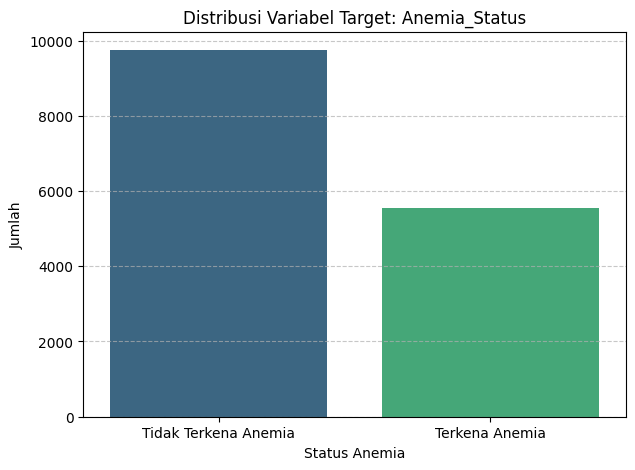

In [103]:
plt.figure(figsize=(7, 5))
sns.countplot(x=new_target_column, data=df, palette='viridis')
plt.title(f'Distribusi Variabel Target: {new_target_column}')
plt.xlabel('Status Anemia')
plt.ylabel('Jumlah')
plt.xticks([0, 1], ['Tidak Terkena Anemia', 'Terkena Anemia'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

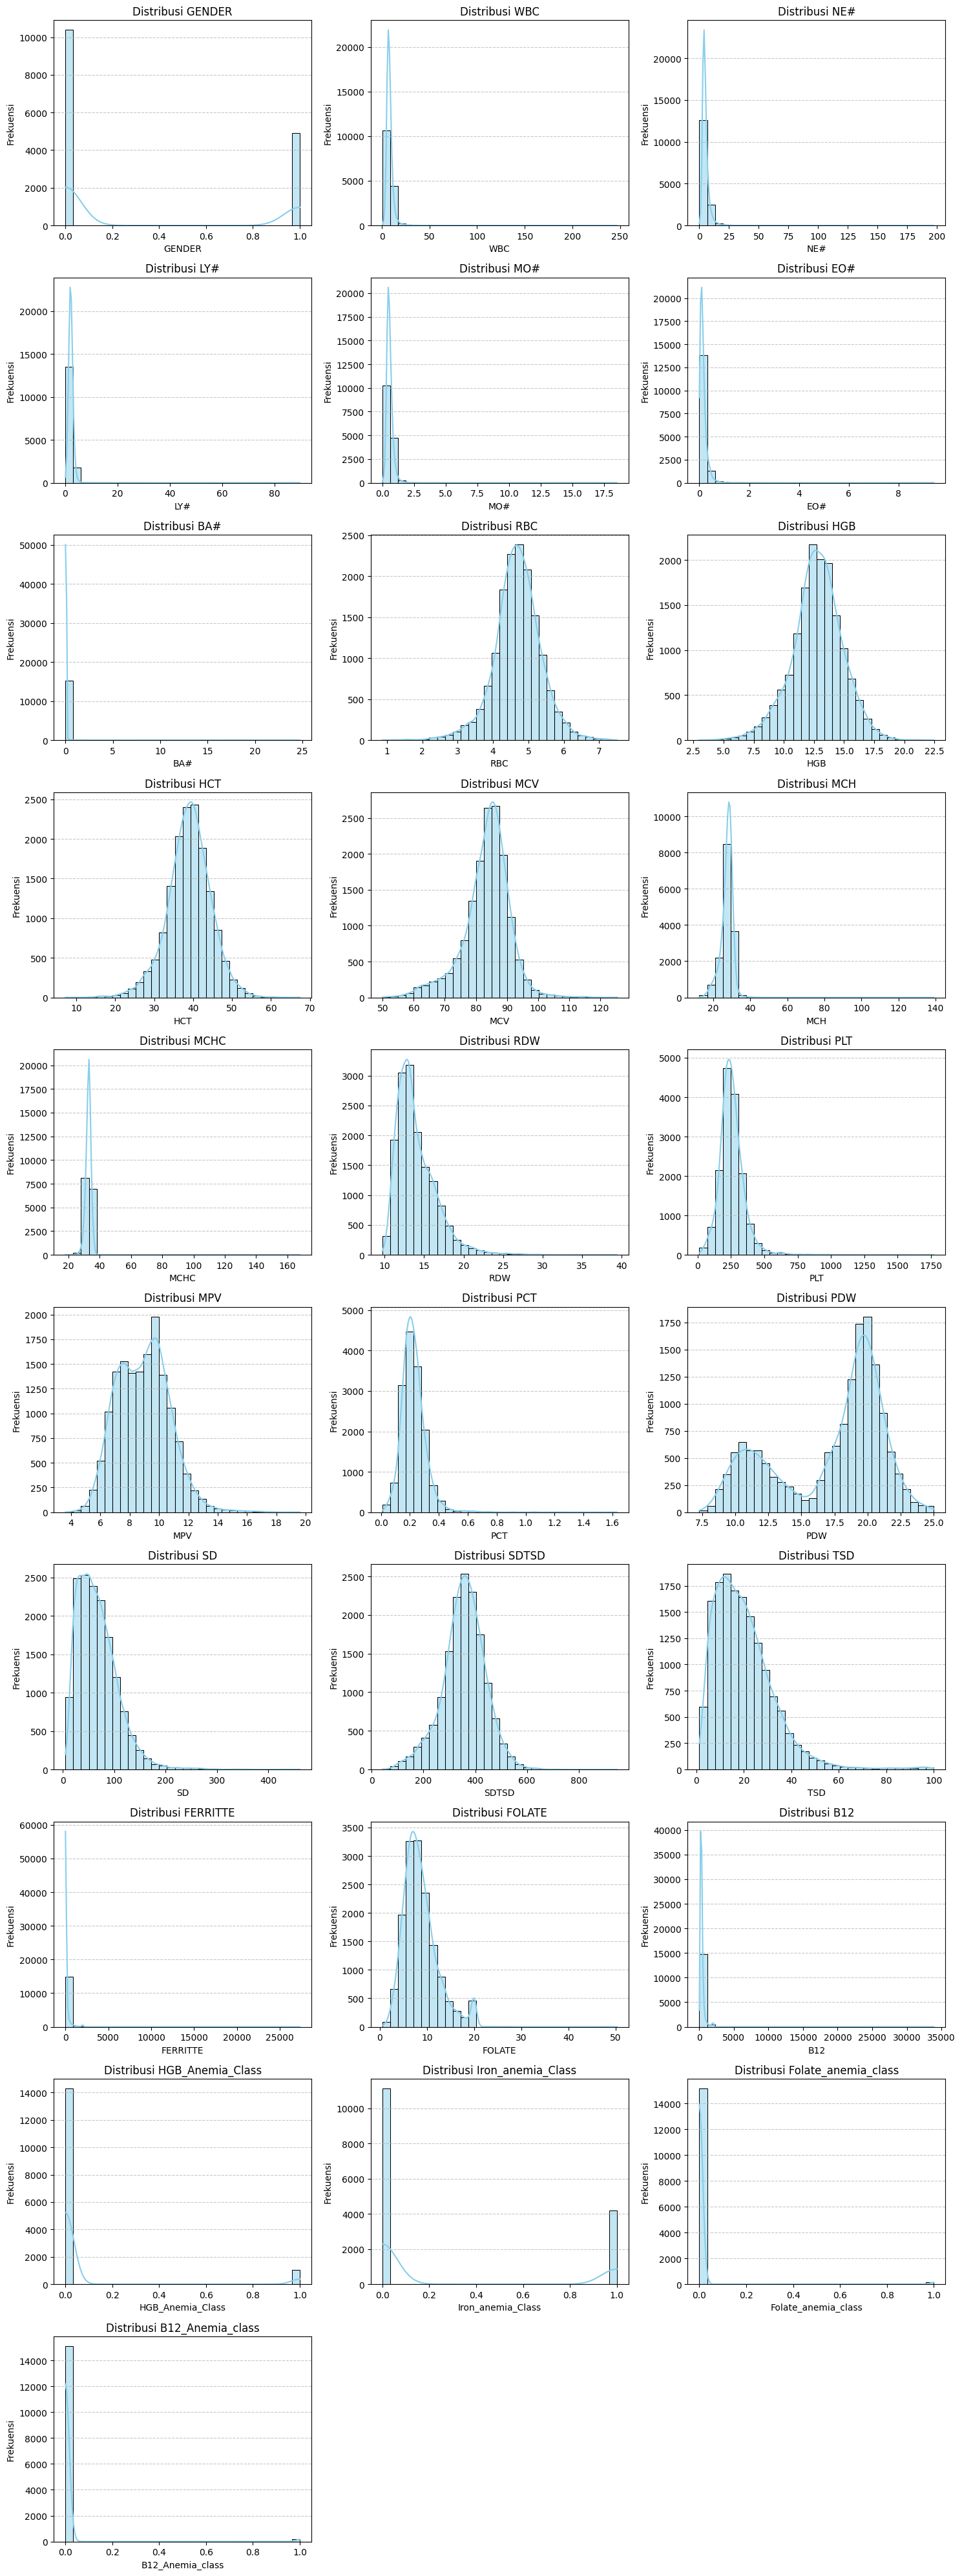

In [105]:
# Plot distribusi fitur numerik (opsional, bisa dihilangkan jika terlalu banyak plot)
numeric_cols_eda = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if original_target_column in numeric_cols_eda:
    numeric_cols_eda.remove(original_target_column)
if new_target_column in numeric_cols_eda:
    numeric_cols_eda.remove(new_target_column)

if len(numeric_cols_eda) > 0:
    n_cols = 3
    n_rows = (len(numeric_cols_eda) + n_cols - 1) // n_cols
    plt.figure(figsize=(5 * n_cols, 4 * n_rows))
    for i, col in enumerate(numeric_cols_eda):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.histplot(df[col], kde=True, bins=30, color='skyblue')
        plt.title(f'Distribusi {col}', fontsize=12)
        plt.xlabel(col, fontsize=10)
        plt.ylabel('Frekuensi', fontsize=10)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada kolom numerik untuk diplot distribusinya (selain target).")

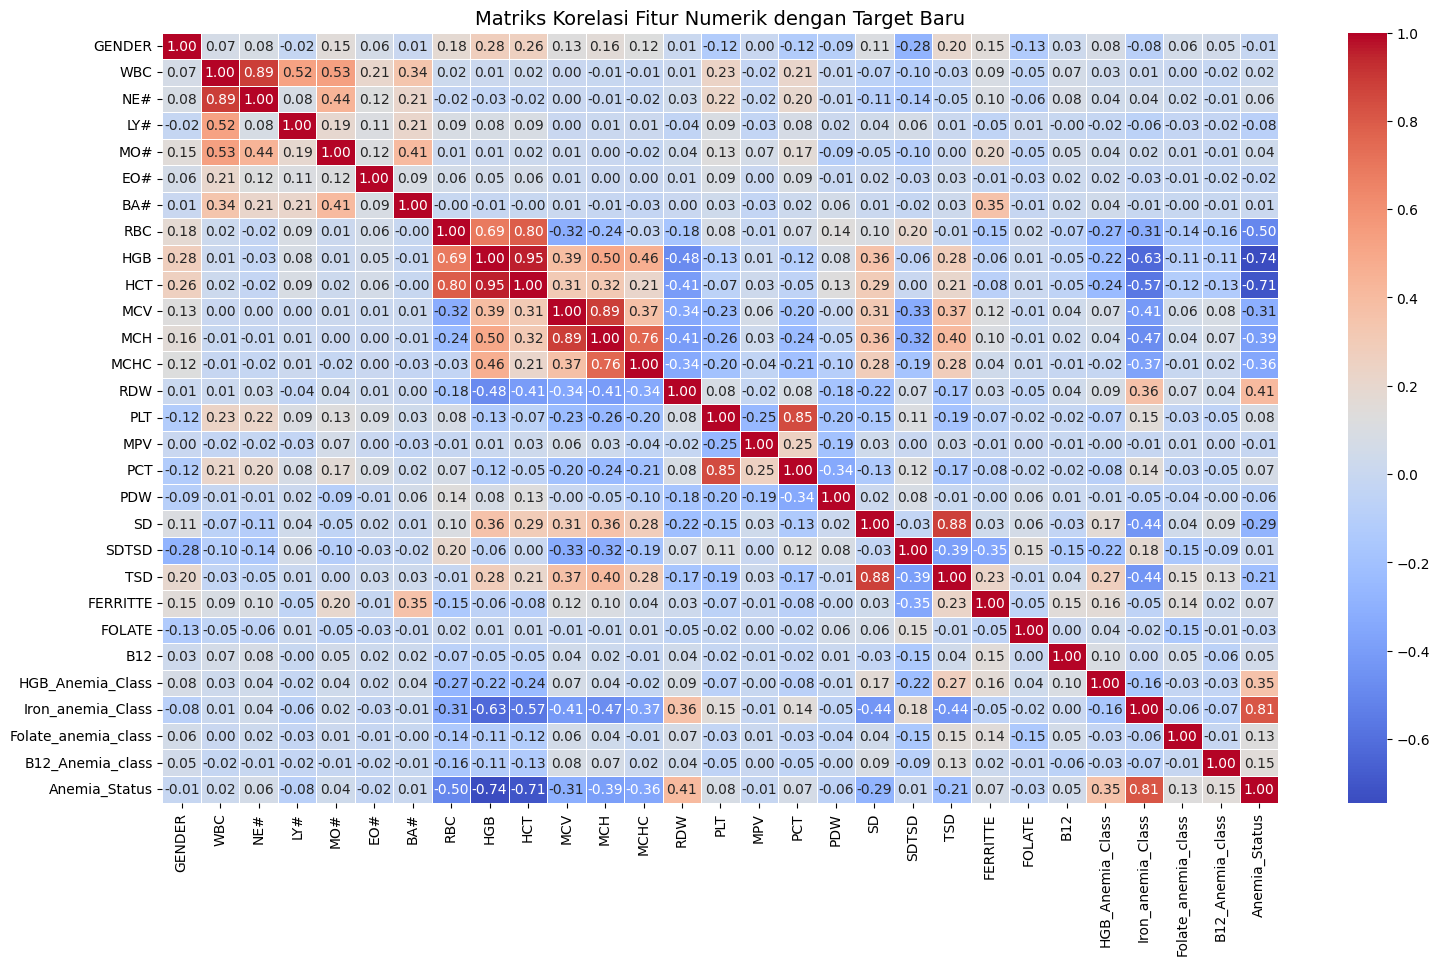

In [107]:
# Matriks Korelasi
if len(numeric_cols_eda) > 1:
    plt.figure(figsize=(18, 10))
    # Korelasi dengan target baru (setelah dipastikan target baru numerik)
    df_for_corr = df[numeric_cols_eda + [new_target_column]].copy()
    sns.heatmap(df_for_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Matriks Korelasi Fitur Numerik dengan Target Baru', fontsize=14)
    plt.show()
else:
    print("Tidak cukup kolom numerik untuk plot matriks korelasi.")

# Feature Selection

In [108]:
# Kolom yang dikecualikan dari pemilihan fitur (label atau turunan)
features_to_exclude = [
    original_target_column, new_target_column,
    'HGB_Anemia_Class', 'Iron_anemia_Class',
    'Folate_anemia_class', 'B12_Anemia_class'
]
features_to_exclude = [col for col in features_to_exclude if col in df.columns]

In [109]:
features_df_for_selection = df.drop(columns=features_to_exclude, errors='ignore').copy()

In [110]:
# Encode sementara kolom kategorikal untuk korelasi
categorical_cols_for_corr = features_df_for_selection.select_dtypes(include=['object', 'category']).columns.tolist()
for col in categorical_cols_for_corr:
    features_df_for_selection[col] = LabelEncoder().fit_transform(features_df_for_selection[col].astype(str))


In [111]:
# Hitung korelasi dengan target baru
correlation_df_final = features_df_for_selection.copy()
correlation_df_final[new_target_column] = df[new_target_column]
correlations_with_target = correlation_df_final.corr(numeric_only=True)[new_target_column].abs().sort_values(ascending=False)


In [112]:
# Ambil 9 fitur dengan korelasi tertinggi (selain target itu sendiri)
final_selected_features = []
count = 0
for feature, correlation_value in correlations_with_target.items():
    if feature == new_target_column:
        continue
    if feature not in features_to_exclude:
        final_selected_features.append(feature)
        count += 1
    if count >= 9:
        break

In [114]:
if len(final_selected_features) < 9:
    print(f"Peringatan: Hanya {len(final_selected_features)} fitur ditemukan. Menambahkan fitur lain.")
    all_available_features = [col for col in df.columns if col not in features_to_exclude and col != new_target_column]
    for feature in all_available_features:
        if feature not in final_selected_features:
            final_selected_features.append(feature)
        if len(final_selected_features) >= 9:
            break

In [115]:
print(f"Jumlah fitur yang dipilih: {len(final_selected_features)}")
print(f"9 Fitur paling berpengaruh: {final_selected_features}")

Jumlah fitur yang dipilih: 9
9 Fitur paling berpengaruh: ['HGB', 'HCT', 'RBC', 'RDW', 'MCH', 'MCHC', 'MCV', 'SD', 'TSD']


# Data Preprocessing 

In [116]:
X = df[final_selected_features].copy()
y = df[new_target_column].copy()

In [117]:
# Identifikasi kolom kategorikal dan numerik di X yang sudah difilter
categorical_cols_final = [col for col in X.columns if X[col].dtype == 'object' or X[col].dtype == 'category']
print(f"Kolom kategorikal untuk encoding: {categorical_cols_final}")


Kolom kategorikal untuk encoding: []


In [118]:
label_encoders = {} # Simpan encoder
for col in categorical_cols_final:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

In [119]:
numeric_cols_for_scaling = [col for col in X.columns if col not in categorical_cols_final]
print(f"Kolom numerik untuk scaling: {numeric_cols_for_scaling}")

Kolom numerik untuk scaling: ['HGB', 'HCT', 'RBC', 'RDW', 'MCH', 'MCHC', 'MCV', 'SD', 'TSD']


In [120]:
scaler = StandardScaler() # Simpan scaler
X[numeric_cols_for_scaling] = scaler.fit_transform(X[numeric_cols_for_scaling])

# Train-Test Split dan SMOTE

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [122]:
print(f"\nUkuran data training sebelum SMOTE: {X_train.shape}")
print(f"Distribusi kelas training sebelum SMOTE:\n{pd.Series(y_train).value_counts()}")


Ukuran data training sebelum SMOTE: (12240, 9)
Distribusi kelas training sebelum SMOTE:
Anemia_Status
0    7798
1    4442
Name: count, dtype: int64


In [123]:
# Terapkan SMOTE pada data training
smote = SMOTE(random_state=42, sampling_strategy='auto')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [124]:
X_train = X_train_resampled
y_train = y_train_resampled

In [125]:
print(f"\nUkuran data training setelah SMOTE: {X_train.shape}")
print(f"Distribusi kelas training setelah SMOTE:\n{pd.Series(y_train).value_counts()}")


Ukuran data training setelah SMOTE: (15596, 9)
Distribusi kelas training setelah SMOTE:
Anemia_Status
1    7798
0    7798
Name: count, dtype: int64


# Model Building (Neural Network)

In [126]:
num_classes = len(np.unique(y_train))

model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],), name='input_features'),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax', name='output_anemia_status')
])

print("\nModel Neural Network berhasil dibangun:")
model.summary()


Model Neural Network berhasil dibangun:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 128)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_anemia_status (Dense)    │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,450 (48.63 KB)

 Trainable params: 12,066 (47.13 KB)

 Non-trainable params: 384 (1.50 KB)

# Model Training

In [127]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

class_weights = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(y_train), y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True
)

In [128]:
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weights_dict,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
439/439 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8527 - loss: 0.3418 - val_accuracy: 0.9224 - val_loss: 0.1706
Epoch 2/200
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9049 - loss: 0.2134 - val_accuracy: 0.9115 - val_loss: 0.1918
Epoch 3/200
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9197 - loss: 0.1840 - val_accuracy: 0.9026 - val_loss: 0.1641
Epoch 4/200
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9223 - loss: 0.1761 - val_accuracy: 0.9064 - val_loss: 0.1479
Epoch 5/200
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9253 - loss: 0.1642 - val_accuracy: 0.9058 - val_loss: 0.1343
Epoch 6/200
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9275 - loss: 0.1693 - val_accuracy: 0.9026 - val_loss: 0.1425
Epoch 7/200
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9287 - loss: 0.1597 - val_accuracy: 0.9026 - val_loss: 0.1280
Epoch 8/200
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9341 - loss: 0.1518 - val_accu

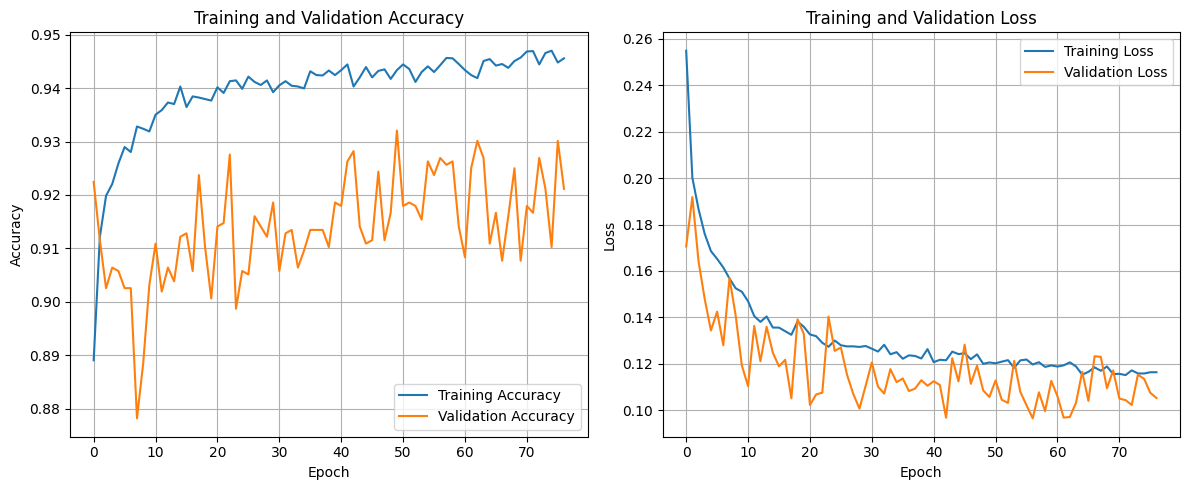

In [129]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model Evaluation

In [130]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss pada data testing: {loss:.4f}")
print(f"Akurasi pada data testing: {accuracy:.4f}")

Loss pada data testing: 0.1227
Akurasi pada data testing: 0.9428


In [131]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [132]:
target_names_binary = ['Tidak Terkena Anemia', 'Terkena Anemia']
print("\n--- Laporan Klasifikasi ---")
print(classification_report(y_test, y_pred, target_names=target_names_binary, zero_division=0))


--- Laporan Klasifikasi ---
                      precision    recall  f1-score   support

Tidak Terkena Anemia       0.95      0.96      0.96      1949
      Terkena Anemia       0.93      0.91      0.92      1111

            accuracy                           0.94      3060
           macro avg       0.94      0.94      0.94      3060
        weighted avg       0.94      0.94      0.94      3060



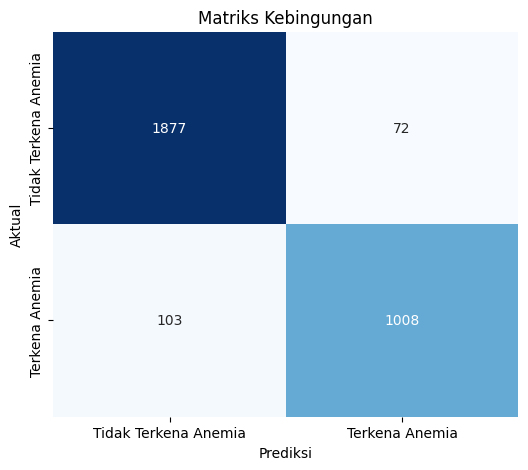

In [133]:
# Matriks Kebingungan
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=target_names_binary, yticklabels=target_names_binary)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Matriks Kebingungan')
plt.show()

# Model Saving dan ONNX Conversion

In [ ]:
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(os.path.join(MODELS_DIR, 'encoders'), exist_ok=True)

# Simpan model Keras (.keras)
model_keras_path = os.path.join(MODELS_DIR, f'{MODEL_NAME}.keras')
model.save(model_keras_path)
print(f"Model Keras telah disimpan sebagai '{model_keras_path}'.")

# Simpan scaler dan label_encoders
with open(os.path.join(MODELS_DIR, 'encoders', 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)
print("Scaler telah disimpan.")

if label_encoders: # Hanya simpan jika ada LabelEncoder yang digunakan
    with open(os.path.join(MODELS_DIR, 'encoders', 'label_encoders.pkl'), 'wb') as f:
        pickle.dump(label_encoders, f)
    print("Label encoders telah disimpan.")

# Konversi ke ONNX
onnx_output_path = os.path.join(MODELS_DIR, f'{MODEL_NAME}.onnx')

try:
    import tf2onnx
    import onnx

    # Eksplisit mengatur output_names untuk model Sequential (solusi yang berhasil)
    if not hasattr(model, 'output_names') or model.output_names is None or len(model.output_names) == 0:
        model.output_names = ["output_anemia_status"] 
    
    # Input specification untuk konversi ONNX
    input_spec_onnx = (tf.TensorSpec((None, X_train.shape[1]), tf.float32, name="input_features"),)

    print(f"\nMencoba konversi model ke ONNX format ({onnx_output_path})...")
    model_proto, _ = tf2onnx.convert.from_keras(
        model,
        input_signature=input_spec_onnx,
        opset=ONNX_OPS_VERSION,
        output_path=onnx_output_path
    )
    print(f"Model berhasil dikonversi ke format ONNX: '{onnx_output_path}'.")
    
    # Verifikasi model ONNX
    onnx_model = onnx.load(onnx_output_path)
    onnx.checker.check_model(onnx_model)
    print("Model ONNX valid.")
    
except ImportError:
    print("Error: Pustaka 'tf2onnx' atau 'onnx' tidak ditemukan. Instal dengan 'pip install tf2onnx onnx'.")
except Exception as e:
    print(f"Error selama konversi ONNX: {str(e)}")

ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x000001D7AA7A64D0>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


Model Keras telah disimpan sebagai 'models\anemia_binary_model.keras'.
Scaler telah disimpan.

Mencoba konversi model ke ONNX format (models\anemia_binary_model.onnx)...
Model berhasil dikonversi ke format ONNX: 'models\anemia_binary_model.onnx'.
Model ONNX valid.


# Inference

In [135]:
# Fungsi Bantu untuk Evaluasi Medis (disesuaikan dengan 9 fitur terpilih)
def evaluate_anemia_status_binary(data_row_original):
    hgb_val = data_row_original.get('HGB')
    mcv_val = data_row_original.get('MCV')
    rdw_val = data_row_original.get('RDW')
    
    hgb_cutoff = 12.0 # Ambil cutoff umum

    is_anemic = False
    reasons = []
    
    hgb_low = False
    if hgb_val is not None and hgb_val < hgb_cutoff:
        hgb_low = True
        is_anemic = True
        reasons.append(f"HGB ({hgb_val:.1f} g/dL) rendah (ambang batas: {hgb_cutoff} g/dL).")

    if hgb_low:
        if mcv_val is not None:
            if mcv_val < 80:
                is_anemic = True
                reasons.append(f"MCV ({mcv_val:.1f}) rendah, mengindikasikan anemia mikrositik.")
            elif mcv_val > 100:
                is_anemic = True
                reasons.append(f"MCV ({mcv_val:.1f}) tinggi, mengindikasikan anemia makrositik.")
        
        if rdw_val is not None and rdw_val > 14.5:
             is_anemic = True
             reasons.append(f"RDW ({rdw_val:.1f}) tinggi, mengindikasikan variasi ukuran sel darah merah (anisositosis).")
        
    if not is_anemic and not reasons:
        reasons.append("Semua parameter utama dalam rentang normal atau tidak menunjukkan defisiensi.")

    return "Terkena Anemia" if is_anemic else "Tidak Terkena Anemia", reasons


# Memuat ulang model yang disimpan (untuk memastikan proses save/load bekerja)
try:
    loaded_model = keras.models.load_model(os.path.join(MODELS_DIR, f'{MODEL_NAME}.keras'))
    print(f"Model berhasil dimuat ulang dari '{os.path.join(MODELS_DIR, f'{MODEL_NAME}.keras')}'.")
except Exception as e:
    print(f"Gagal memuat ulang model: {e}. Menggunakan model yang ada dalam memori.")
    loaded_model = model

# Label mapping untuk inferensi 2 kelas
inference_labels_binary_mapping = {
    0: "Tidak Terkena Anemia",
    1: "Terkena Anemia"
}

# --- Data Baru yang Dideklarasikan Langsung di Kode untuk Inferensi ---
# Pastikan kolom-kolom ini sesuai dengan `final_selected_features` dari pelatihan model Anda.
# Fitur-fitur terpilih: ['HGB', 'HCT', 'RBC', 'RDW', 'MCH', 'MCHC', 'MCV', 'SD', 'TSD']
new_data_raw_list = [
    { # Pasien 1: Contoh Tidak Anemia
        'HGB': 14.5, 'HCT': 42.0, 'RBC': 5.0, 'RDW': 11.5,
        'MCH': 29.0, 'MCHC': 33.0, 'MCV': 89.0, 'SD': 40.0, 'TSD': 50.0
    },
    { # Pasien 2: Contoh Anemia (HGB rendah, MCV tinggi, RDW tinggi)
        'HGB': 10.2, 'HCT': 32.0, 'RBC': 3.8, 'RDW': 15.0,
        'MCH': 27.0, 'MCHC': 31.0, 'MCV': 105.0, 'SD': 45.0, 'TSD': 55.0
    },
    { # Pasien 3: Contoh Anemia (HGB rendah, MCH & MCHC sedikit rendah)
        'HGB': 11.8, 'HCT': 36.0, 'RBC': 4.3, 'RDW': 13.0,
        'MCH': 25.0, 'MCHC': 30.0, 'MCV': 95.0, 'SD': 42.0, 'TSD': 52.0
    }
]
new_data_raw = pd.DataFrame(new_data_raw_list)

print(f"\n--- Data Input Baru untuk Inferensi ({len(new_data_raw)} Pasien) ---")
print(new_data_raw.to_string()) # Tampilkan seluruh DataFrame jika kecil


# --- Preprocessing Data Baru untuk Inferensi ---
new_data_processed = new_data_raw.copy()

# Pastikan urutan kolom sesuai dengan pelatihan model
try:
    new_data_processed = new_data_processed[X_train.columns]
except KeyError as e:
    print(f"Error: Kolom data baru tidak sesuai dengan model. Missing: {e}")
    print(f"Diharapkan: {X_train.columns.tolist()}")
    print(f"Tersedia: {new_data_raw.columns.tolist()}")
    # Opsional: sys.exit() jika ini adalah error fatal untuk aplikasi Anda
    
# Encoding kolom kategorikal (jika ada)
for col in categorical_cols_final:
    if col in label_encoders:
        new_data_processed[col] = new_data_processed[col].astype(str)
        # Handle unknown values if any, by mapping to mode of training data
        unknown_values = set(new_data_processed[col].unique()) - set(label_encoders[col].classes_)
        if unknown_values:
            mode_val_train_encoded = X_train[col].mode()[0]
            mode_val_train_original = label_encoders[col].inverse_transform([mode_val_train_encoded])[0]
            new_data_processed[col] = new_data_processed[col].apply(
                lambda x: mode_val_train_original if x in unknown_values else x
            )
        new_data_processed[col] = label_encoders[col].transform(new_data_processed[col])
        
# Normalisasi fitur numerik
for col in numeric_cols_for_scaling:
    new_data_processed[col] = pd.to_numeric(new_data_processed[col], errors='coerce')
    new_data_processed[col].fillna(X_train[col].median(), inplace=True) # Isi NaN dengan median training
try:
    new_data_processed[numeric_cols_for_scaling] = scaler.transform(new_data_processed[numeric_cols_for_scaling])
except Exception as e:
    print(f"Error saat normalisasi data baru: {e}")


# --- Melakukan Prediksi ---
new_predictions_proba = loaded_model.predict(new_data_processed)
new_predictions_indices = np.argmax(new_predictions_proba, axis=1)


# --- Hasil Inferensi dan Verifikasi ---
print("\n" + "="*50)
print("--- Hasil Prediksi dan Evaluasi Medis ---")
print("="*50 + "\n")

for i in range(len(new_data_raw)):
    data_row_original = new_data_raw.iloc[i].to_dict()
    predicted_idx = new_predictions_indices[i]
    predicted_label = inference_labels_binary_mapping.get(predicted_idx, f"Kelas tidak dikenal ({predicted_idx})")
    proba = new_predictions_proba[i]

    print(f"\n=== Analisis Pasien ke-{i+1} ===")
    print("----------------------------------")
    
    print("\n[ Data Input (Fitur Pilihan) ]")
    for k, v in data_row_original.items():
        print(f"  {k:<10}: {v}")

    med_eval_status, med_eval_reasons = evaluate_anemia_status_binary(data_row_original)
    print("\n[ Evaluasi Medis (Berdasarkan Kriteria Umum) ]")
    print(f"  Status Anemia: {med_eval_status}")
    print("  Alasan:")
    for reason in med_eval_reasons:
        print(f"    - {reason}")

    print("\n[ Hasil Prediksi Model NN ]")
    print(f"  Prediksi Model: **{predicted_label}**")
    
    prob_output = ", ".join([f"{inference_labels_binary_mapping.get(j, f'Kelas {j}')}: {p:.2%}" for j, p in enumerate(proba)])
    print(f"  Probabilitas: {prob_output}")

    print("\n[ Ringkasan Perbandingan ]")
    print(f"  - Prediksi Model: {predicted_label}")
    print(f"  - Evaluasi Medis: {med_eval_status}")
    
    if predicted_label == med_eval_status:
        print("  -> **Konsisten** antara Prediksi Model dan Evaluasi Medis.")
    else:
        print("  -> **Disparitas** antara Prediksi Model dan Evaluasi Medis. Perlu investigasi lebih lanjut.")
    print("----------------------------------")

Model berhasil dimuat ulang dari 'models\anemia_binary_model.keras'.

--- Data Input Baru untuk Inferensi (3 Pasien) ---
    HGB   HCT  RBC   RDW   MCH  MCHC    MCV    SD   TSD
0  14.5  42.0  5.0  11.5  29.0  33.0   89.0  40.0  50.0
1  10.2  32.0  3.8  15.0  27.0  31.0  105.0  45.0  55.0
2  11.8  36.0  4.3  13.0  25.0  30.0   95.0  42.0  52.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step

--- Hasil Prediksi dan Evaluasi Medis ---


=== Analisis Pasien ke-1 ===
----------------------------------

[ Data Input (Fitur Pilihan) ]
  HGB       : 14.5
  HCT       : 42.0
  RBC       : 5.0
  RDW       : 11.5
  MCH       : 29.0
  MCHC      : 33.0
  MCV       : 89.0
  SD        : 40.0
  TSD       : 50.0

[ Evaluasi Medis (Berdasarkan Kriteria Umum) ]
  Status Anemia: Tidak Terkena Anemia
  Alasan:
    - Semua parameter utama dalam rentang normal atau tidak menunjukkan defisiensi.

[ Hasil Prediksi Model NN ]
  Prediksi Model: **Tidak Terkena Anemia**
  Probabilitas: Tidak Terkena Anemia: 100.00%, Terkena

C:\Users\ghani\AppData\Local\Temp\ipykernel_30132\1332153343.py:103: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_data_processed[col].fillna(X_train[col].median(), inplace=True) # Isi NaN dengan median training
C:\Users\ghani\AppData\Local\Temp\ipykernel_30132\1332153343.py:103: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which 